In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics

# gpu or cpu enviroment

In [4]:
#os.environ['CUDA_VISIBLE_DEVICES']=''

# load data function

In [5]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

# params config class

In [6]:
class Config(object):
    """
    A class to store parameters, the input should be feature mat of training and testing
    Note: it would be more interesting to use a HyperOpt search space:
    https://github.com/hyperopt/hyperopt
    """
    def __init__(self, X_train, X_test):
        # Input data
        self.train_count = len(X_train)  # 11855 training series
        self.test_data_count = len(X_test)  # 662 testing series
        self.n_steps = len(X_train[0])  # 117 time_steps (features) per series

        # Training
        self.learning_rate = 0.0025
        self.lambda_loss_amount = 0.0015
        self.training_epochs = self.train_count * 300
        self.batch_size = 1500
        self.display_iter = 30000  # To show test set accuracy during training

        # LSTM structure
        # Features count is of 1 (1*3D sensors features over time)
        self.n_inputs = len(X_train[0][0]) # 1
        self.n_hidden = 32  # nb of neurons inside the neural network
        self.n_classes = 6  # Final output classes
        
        self.W = {
            'hidden': tf.Variable(tf.random_normal([self.n_inputs, self.n_hidden])),
            'output': tf.Variable(tf.random_normal([self.n_hidden, self.n_classes]))}
        self.biases = {
            'hidden': tf.Variable(tf.random_normal([self.n_hidden], mean=1.0)),
            'output': tf.Variable(tf.random_normal([self.n_classes]))}

# lstm network function

In [7]:
def LSTM_Network(_X, config):
    """
    Two LSTM cells are stacked which adds deepness to the neural network.
    Args:
            _X: ndarray feature matrix, shape: [batch_size, time_steps, n_inputs]
        return: matrix  output shape [batch_size,n_classes]
    """
    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, config.n_inputs])
    # new shape: (n_steps*batch_size, n_input)

    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, config.W['hidden']) + config.biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, config.n_steps, 0)
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, forget_bias=1.0, 
                  state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], 
                  state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier,
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]

    # Linear activation
    return tf.matmul(lstm_last_output, config.W['output']) + config.biases['output']

# extract batch function

In [8]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s

# one hot function

In [9]:
def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    n_values = config.n_classes
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

# load and prepare data

In [11]:
# Output classes to learn how to classify
labels = ["WALKING", "SITTING", "LAYING"]

data_path = "../../dataset/"
dataset_path = data_path + "data/"
print("\n" + "Dataset is now located at: " + dataset_path)

X_train_signals_path = dataset_path + "train_set.txt"
X_test_signals_path = dataset_path + "test_set.txt"
X_train = load_X(X_train_signals_path)
X_test = load_X(X_test_signals_path)

y_train_path = dataset_path + "train_labels.txt"
y_test_path = dataset_path + "test_labels.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ../../dataset/data/


# define parameters for model

In [13]:
config = Config(X_train, X_test)
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("features shape, labels shape, each features mean, each features standard deviation")
print(X_test.shape, y_test.shape,
      np.mean(X_test), np.std(X_test))
print("the dataset is therefore properly normalised, as expected.")

Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
((662, 117, 1), (662, 1), 51.391392, 128.30371)
the dataset is therefore properly normalised, as expected.


# build the neural network

In [14]:
x = tf.placeholder(tf.float32, [None, config.n_steps, config.n_inputs])
y = tf.placeholder(tf.float32, [None, config.n_classes])

pred_y = LSTM_Network(x, config)

# Loss,optimizer,evaluation
l2 = config.lambda_loss_amount * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())
# Softmax loss and L2
cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred_y)) + l2
optimizer = tf.train.AdamOptimizer(
    learning_rate=config.learning_rate).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred_y, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

# train the neural network

In [16]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
# Note that log_device_placement can be turned ON but will cause console spam with RNNs.
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=False))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * config.batch_size <= config.training_epochs:
    batch_xs = extract_batch_size(X_train, step, config.batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, config.batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run([optimizer, cost, accuracy],
        feed_dict={x: batch_xs, y: batch_ys})

    train_losses.append(loss)
    train_accuracies.append(acc)  

    # Evaluate network only at some steps for faster training: 
    if (step*config.batch_size % config.display_iter == 0) or (step == 1) \
        or (step * config.batch_size > config.training_epochs):

        # To not spam console, show training accuracy/loss in this "if"
        print("Training epochs #" + str(step*config.batch_size) + \
          ":   Batch Loss = " + "{:.6f}".format(loss) + \
          ", Accuracy = {}".format(acc))

        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run([cost, accuracy], feed_dict={x: X_test, y: one_hot(y_test)})

        test_losses.append(loss)
        test_accuracies.append(acc)

        print("Performance on test set: " + "Batch Loss = {}".format(loss) + \
            ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data
one_hot_predictions, accuracy, final_loss = sess.run([pred_y, accuracy, cost],
    feed_dict={x: X_test, y: one_hot(y_test)})

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("Final result: " + "Batch Loss = {}".format(final_loss) + \
    ", Accuracy = {}".format(accuracy))

Training epochs #1500:   Batch Loss = 0.652865, Accuracy = 1.00000011921
Performance on test set: Batch Loss = 2.53529143333, Accuracy = 0.444108784199
Training epochs #30000:   Batch Loss = 1.208007, Accuracy = 0.601999998093
Performance on test set: Batch Loss = 1.34562575817, Accuracy = 0.444108784199
Training epochs #60000:   Batch Loss = 1.951398, Accuracy = 0.198666661978
Performance on test set: Batch Loss = 1.29923033714, Accuracy = 0.518126904964
Training epochs #90000:   Batch Loss = 1.222713, Accuracy = 0.414000034332
Performance on test set: Batch Loss = 1.29317092896, Accuracy = 0.425981849432
Training epochs #120000:   Batch Loss = 1.154558, Accuracy = 0.587999939919
Performance on test set: Batch Loss = 1.27632009983, Accuracy = 0.560423016548
Training epochs #150000:   Batch Loss = 1.214364, Accuracy = 0.383999973536
Performance on test set: Batch Loss = 1.27431035042, Accuracy = 0.421450167894
Training epochs #180000:   Batch Loss = 1.067307, Accuracy = 0.676000058651


Training epochs #1590000:   Batch Loss = 0.965055, Accuracy = 0.699333310127
Performance on test set: Batch Loss = 1.1184643507, Accuracy = 0.432024180889
Training epochs #1620000:   Batch Loss = 1.035575, Accuracy = 0.302000015974
Performance on test set: Batch Loss = 1.12197053432, Accuracy = 0.421450167894
Training epochs #1650000:   Batch Loss = 0.875475, Accuracy = 0.840000033379
Performance on test set: Batch Loss = 1.11635684967, Accuracy = 0.425981879234
Training epochs #1680000:   Batch Loss = 1.001268, Accuracy = 0.362666666508
Performance on test set: Batch Loss = 1.11873221397, Accuracy = 0.422960698605
Training epochs #1710000:   Batch Loss = 0.886577, Accuracy = 0.765333414078
Performance on test set: Batch Loss = 1.11390173435, Accuracy = 0.424471288919
Training epochs #1740000:   Batch Loss = 0.894906, Accuracy = 0.523999929428
Performance on test set: Batch Loss = 1.11594367027, Accuracy = 0.424471318722
Training epochs #1770000:   Batch Loss = 0.907338, Accuracy = 0.6

Training epochs #3180000:   Batch Loss = 0.857622, Accuracy = 0.811999976635
Performance on test set: Batch Loss = 1.10013985634, Accuracy = 0.419939577579
Training epochs #3210000:   Batch Loss = 0.881256, Accuracy = 0.502666592598
Performance on test set: Batch Loss = 1.10129117966, Accuracy = 0.421450138092
Training epochs #3240000:   Batch Loss = 0.880247, Accuracy = 0.695333302021
Performance on test set: Batch Loss = 1.09850764275, Accuracy = 0.419939577579
Training epochs #3270000:   Batch Loss = 0.838097, Accuracy = 0.557999968529
Performance on test set: Batch Loss = 1.09840834141, Accuracy = 0.424471318722
Training epochs #3300000:   Batch Loss = 0.999535, Accuracy = 0.581999957561
Performance on test set: Batch Loss = 1.09678089619, Accuracy = 0.419939577579
Training epochs #3330000:   Batch Loss = 0.963092, Accuracy = 0.40000000596
Performance on test set: Batch Loss = 1.09552037716, Accuracy = 0.419939577579
Training epochs #3360000:   Batch Loss = 0.989209, Accuracy = 0.6

# visual insight 

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


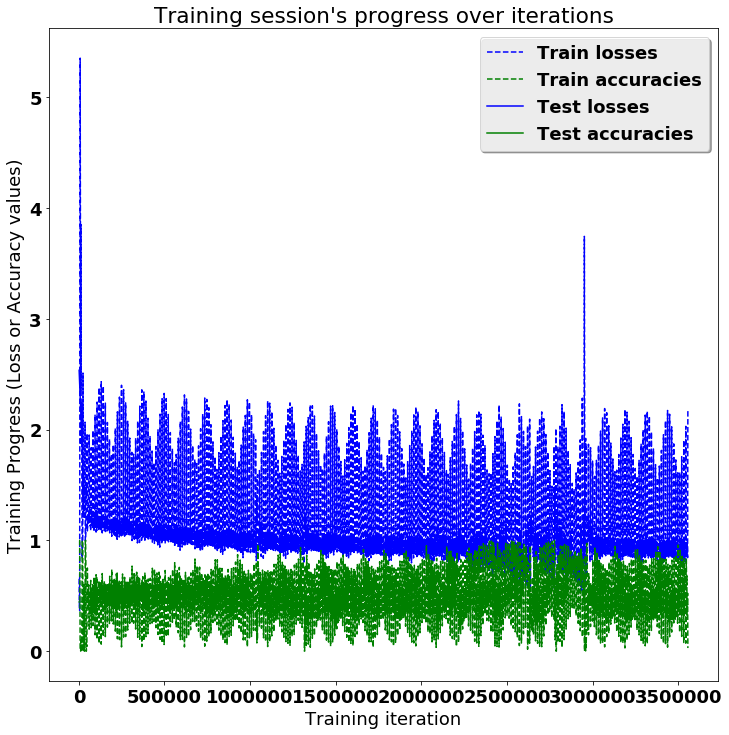

In [17]:
font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 18}

matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(config.batch_size, 
    (len(train_losses)+1)*config.batch_size, config.batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(config.batch_size, 
    len(test_losses)*config.display_iter, config.display_iter)[:-1]), 
    [config.training_epochs])

plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('har_lstm_loss_accuracy.png')
plt.show()

# multi-class confusion matrix and metrics plot

Testing Accuracy: 42.1450167894%

Precision: 34.2043103952%
Recall: 42.1450151057%
f1_score: 36.3195437347%

Confusion Matrix:
[[222  72   0]
 [240  57   0]
 [  4  67   0]]

Confusion matrix (normalised to % of total test data):
[[ 33.53474426  10.87613297   0.        ]
 [ 36.25377655   8.61027145   0.        ]
 [  0.60422963  10.12084579   0.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is     correctly classifier in the last category.


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


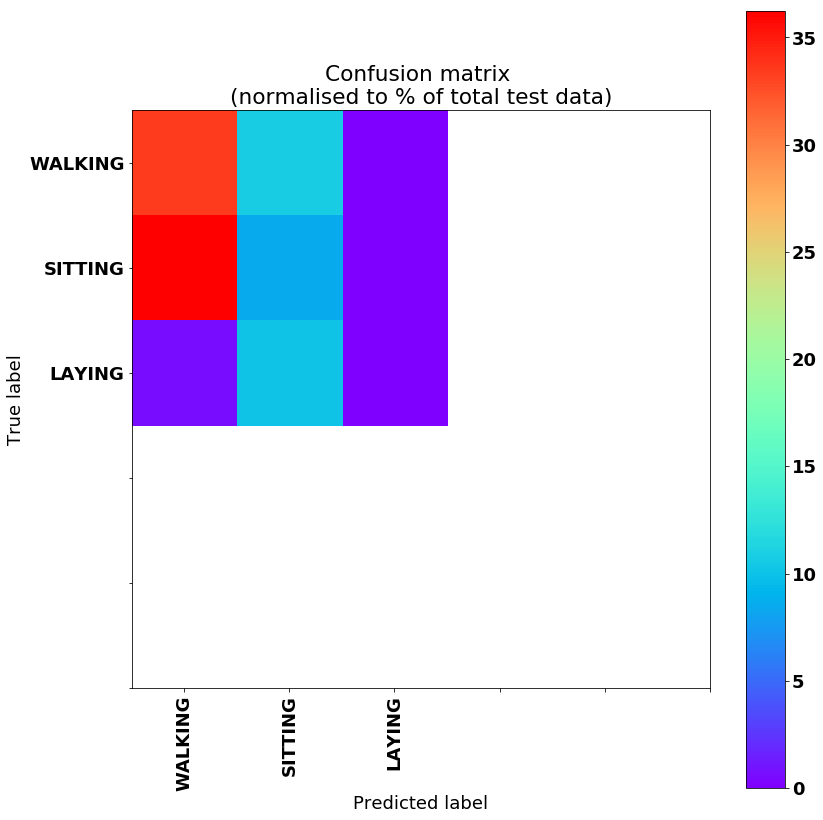

In [18]:
# Results
predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, 
    dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is \
    correctly classifier in the last category.")

# Plot: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(normalised_confusion_matrix, interpolation='nearest', cmap=plt.cm.rainbow)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(config.n_classes)
plt.xticks(tick_marks, labels, rotation=90)
plt.yticks(tick_marks, labels)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('har_lstm_confusion_matrix_heatmap.png')
plt.show()